In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import string
import time
from sklearn import datasets, linear_model
from sklearn import cross_validation, metrics
%matplotlib inline


C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [3]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [5]:
train[train['is_duplicate']==1]

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1
15,15,31,32,What would a Trump presidency mean for current...,How will a Trump presidency affect the student...,1
16,16,33,34,What does manipulation mean?,What does manipulation means?,1
18,18,37,38,Why are so many Quora users posting questions ...,Why do people ask Quora questions which can be...,1
20,20,41,42,Why do rockets look white?,Why are rockets and boosters painted white?,1
29,29,59,60,How should I prepare for CA final law?,How one should know that he/she completely pre...,1


In [6]:
#############Prep Train#####################
train=train.fillna('----')
test=test.fillna('----')

In [7]:
def simPct(a, b):
    countEq=0
    countTot=0
    a = ''.join([x for x in a if not x in string.punctuation])
    b = ''.join([x for x in b if not x in string.punctuation])
    for x in a.split(' '):
        if x in b.split(' '):
            countEq = countEq + 1
        countTot=countTot+1
    return countEq/countTot

In [8]:
def pctLikelihood(pct):
    sz0=train[(train['is_duplicate']==0) & (train['simPct']>pct-0.05) & (train['simPct']<pct+0.05)].shape[0]
    sz1=train[(train['is_duplicate']==1) & (train['simPct']>pct-0.05) & (train['simPct']<pct+0.05)].shape[0]
    return sz1/(sz0+sz1)

In [9]:
train['simPct'] = train.apply(lambda row: 
                              simPct(row['question1'],row['question2'])
                              ,axis=1)

In [10]:
likelihood = pd.DataFrame(columns = {'rdSimPct': [], 'likelihood':[]})
likelihood['rdSimPct']=np.arange(0,1.01,0.01)
likelihood['likelihood']=likelihood.apply(lambda row: pctLikelihood(row['rdSimPct']) ,axis=1)
likelihood['rdSimPct']=likelihood.apply(lambda row: "{0:.2f}".format(row['rdSimPct']),axis=1)

In [11]:
start = time.time()
train['rdSimPct'] = train.apply(lambda row:
                              "{0:.2f}".format(row['simPct'])
                             ,axis=1)
duration = time.time() - start
print(str(int(duration//60)) + " Minute(s), " + str(int(duration%60)) + " Second(s).")

0 Minute(s), 7 Second(s).


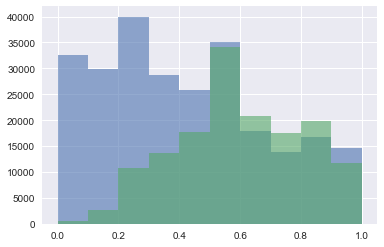

In [12]:
plt.figure(1)
train['simPct'][train['is_duplicate']==0].hist(alpha=0.6)
train['simPct'][train['is_duplicate']==1].hist(alpha=0.6)
plt.show()

In [13]:
regr = linear_model.LinearRegression()

def seriesRegr(X_Series, Y_Series, plot=False):
    npX = X_Series.as_matrix()[:, np.newaxis]
    npY = Y_Series.as_matrix()
    regr.fit(npX, npY)
    if plot:
        # The coefficients
        print('Coefficients: \n', regr.coef_)
        # The mean squared error
        print("Mean squared error: %.2f"
              % np.mean((regr.predict(npX) - npY) ** 2))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % regr.score(npX, npY))

        # Plot outputs
        plt.scatter(npX, npY,  color='black')
        plt.plot(npX, regr.predict(npX), color='blue',
                 linewidth=3)

        plt.xticks(())
        plt.yticks(())

        plt.show()
    return [regr.coef_[0],regr.score(npX, npY)]

def regApply(Season, Team, Years=2):
    select = (trend['Season']>(Season-Years)) & (trend['Season']<=Season) & (trend['team']==Team)
    X_Series = trend['absNum'][select]
    Y_Series = trend['ELO'][select]
    return seriesRegr(X_Series, Y_Series)

Coefficients: 
 [ 0.5489808]
Mean squared error: 0.01
Variance score: 0.73


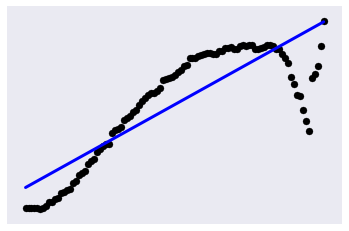

[0.54898079782362319, 0.72618406780927425]

In [14]:
seriesRegr(likelihood.apply(lambda row: float(row['rdSimPct']),axis=1),likelihood['likelihood'],True)

In [15]:
train = pd.merge(train,likelihood, on='rdSimPct')

In [16]:
train.iloc[404284]['rdSimPct']

'0.51'

In [18]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,simPct,rdSimPct,likelihood
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.928571,0.93,0.343347
1,14,29,30,What are the laws to change your status from a...,What are the laws to change your status from a...,0,0.931034,0.93,0.343347
2,25,51,52,What are some tips on making it through the jo...,What are some tips on making it through the jo...,0,0.928571,0.93,0.343347
3,44,89,90,What universities does Rexnord recruit new gra...,What universities does B&G Foods recruit new g...,0,0.928571,0.93,0.343347
4,356,710,711,What universities does Powell Industries recru...,What universities does Chart Industries recrui...,0,0.933333,0.93,0.343347


In [26]:
print("LogLoss Score (Train): %f" % metrics.log_loss(train['is_duplicate'], train['simPct']))

LogLoss Score (Train): 0.968772
